# Disf + TBM Segmentation
---
Applying DISF as pre-segmentation method and TBM as superpixel classifier to obtain segmentation on FoxP3+S

## Initial Setup

In [1]:
# Necessary Imports
import sys
sys.path.append("../../DISF/python3/")
sys.path.append("../../iDISF/python3/")
sys.path.append("../../")
#sys.path.append("../../scripts")

from idisf import iDISF_scribbles
from disf import DISF_Superpixels
from scripts.segmentation_utils import *
from PIL import Image
from scripts.utils import *
from scripts.superpixel_treatment import *
from ptk_code.utils import *
from ptk_code.TBM_PLOT import batch_PLOT

import datetime
import matplotlib.pyplot as plt
import joblib
import numpy as np
import cv2

/home/gustavo/tcc/PytranskitOnCells/ptk_veenv/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/gustavo/tcc/PytranskitOnCells/ptk_veenv/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/gustavo/tcc/PytranskitOnCells/ptk_veenv/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/gustavo/tcc/PytranskitOnCells/ptk_veenv/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


## Obtaining Data

Obtaining the images and setting up the DISF parameters

In [2]:
INPUT_IMAGE_NAME = '2.png'
img = np.array(Image.open(f"../../data/cells_dataset/original/{INPUT_IMAGE_NAME}"), dtype= 'int32');
gt = np.array(Image.open(f"../../data/cells_dataset/labels/{INPUT_IMAGE_NAME}"), dtype = 'int32')

Generating the superpixel labels

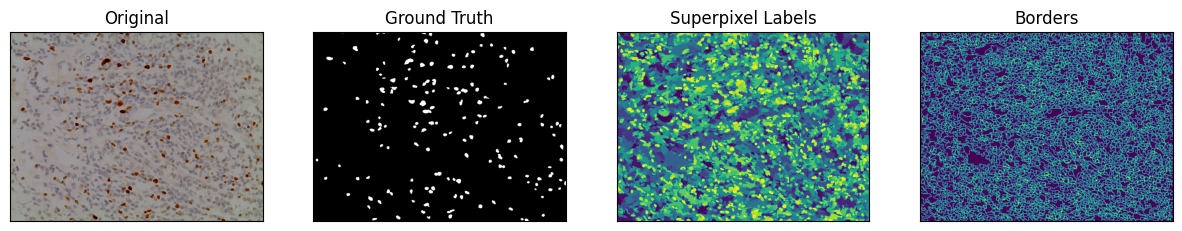

In [3]:
num_init_seeds = 7000;
num_final_superpixels = 4000;
# Generatomg the superpixels
superpixel_label_img, border_img = DISF_Superpixels(img, num_init_seeds, num_final_superpixels)
label_img = superpixel_label_img.copy()
visualize(original = img, ground_truth = gt,  superpixel_labels = superpixel_label_img, borders = border_img)

In [4]:
# Loading the classifier weights
plot_ns_model = joblib.load('../../checkpoints/immuno_cells_3/300.pkl')
plot_ns_model

In [5]:
def get_positive_ids(predictions, superpixel_indexes):
    positive_preds = []
    for i, prediction in enumerate(predictions):
        if prediction == 1:
            positive_preds.append(superpixel_indexes[i])
    return positive_preds

In [6]:
def segment_cells_img(img, marker_img):
    """
    Returns the segmentation labels and
    the borders given an image and it's respective markers
    """

    n0 = 0
    iterations = 1
    f = 1
    c1 = 0.1
    c2 = 0.1
    segm_method = 1
    all_borders = 1

    # applying ultimate erosion on the prediction image
    eroded_img = get_ultimate_erosion(marker_img)
    # generating scribbles for iDISF
    num_obj, markers_coords, scribbles_sizes = get_markers(eroded_img)

    # returning the segmentation and the borders
    segm, borders =  iDISF_scribbles(
        img,
        n0,
        iterations,
        np.array(markers_coords),
        np.array(scribbles_sizes),
        num_obj,
        f,
        c1,
        c2,
        segm_method,
        all_borders
    )
    # Applies tresholding to the segmentation image and
    _, threhsholded_img = cv2.threshold(np.uint8(segm * 255 // 2), 200, 255, cv2.THRESH_BINARY)
    return cv2.bitwise_not(threhsholded_img), borders

## Making predictions

In [7]:
def get_predictions(classifier, input_batch: list[np.array]) -> list[int]:
    """
    Applies the TBM transform and predicts on the dataset
    """
    # Loading mock train dataset
    dataset = 'immuno_cells_3'
    train_dir = '../../data/'+dataset+'/training/'
    (mock_x_train, y_train) = load_image_data(train_dir)
    # Obtaining the test dataset
    x_input = np.array([np.float64(rgb2gray(datapoint)) for datapoint in input_batch])
    # Applying transform
    batch_plot = batch_PLOT(Nmasses = 300)
    x_template=np.mean(mock_x_train,axis=0)
    #mock_x_train = np.uint8(mock_x_train)
    #x_input = np.uint8(x_input)
    mock_x_train_hat, x_input_hat, Pl_tem, P_tem = batch_plot.forward_seq(mock_x_train, x_input, x_template)
    # Making predictions
    preds = classifier.predict(x_input_hat)
    return preds

Filtering only the superpixels wich passes on the mean channel threshold. 

In [8]:
# Obtaining the ids of the generated superpixels
superpixel_ids = np.unique(label_img)
superpixel_ids = superpixel_ids[1:] # Excluding the first empty superpixel

segmented_superpixels = []
segmented_superpixels_ids = []


for superpixel_id in superpixel_ids:
    superpixel_img = get_superpixel_img(label_img, superpixel_id)
    cropped_original_img,cropped_superpixel_img = get_cropped_superpixel_img(img, superpixel_img)
    segmented = apply_mask(cropped_original_img, cropped_superpixel_img)
    segmented_superpixels.append(segmented)
    segmented_superpixels_ids.append(superpixel_id)

filtered_ids, filtered_superpixels = filter_superpixels_by_color_mean(segmented_superpixels_ids, segmented_superpixels)
classified_superpixels_img = get_reconstructed_image(label_img, filtered_ids)
print(f"{len(filtered_ids)} will be used on the classification.")

213 will be used on the classification.


Obtains the predictions with the higher amount of cells

In [9]:
higher_num_of_predictions = 0
tries = 5
positive_ids = []
all_predictions = []
for i in range(tries):
    current_positive_ids = []
    predictions = get_predictions(plot_ns_model,filtered_superpixels)
    current_positive_ids = get_positive_ids(predictions, filtered_ids)
    print(f"Current iteration predicted superpixels: {len(current_positive_ids)}, previous higher: {higher_num_of_predictions}")
    all_predictions.append(current_positive_ids)
    if len(current_positive_ids) > higher_num_of_predictions:
        higher_num_of_predictions = len(positive_ids)
        positive_ids = current_positive_ids.copy()
print(f"{higher_num_of_predictions} superpixels were classified as positive cells.")

Len basis: 30
Current iteration predicted superpixels: 51, previous higher: 0
Len basis: 30
Current iteration predicted superpixels: 213, previous higher: 0
Len basis: 30
Current iteration predicted superpixels: 14, previous higher: 51
Len basis: 30
Current iteration predicted superpixels: 34, previous higher: 51
Len basis: 30
Current iteration predicted superpixels: 213, previous higher: 51
213 superpixels were classified as positive cells.


Reconstructing the image with only the superpixels that were classified as positive

In [10]:
len(positive_ids)

213

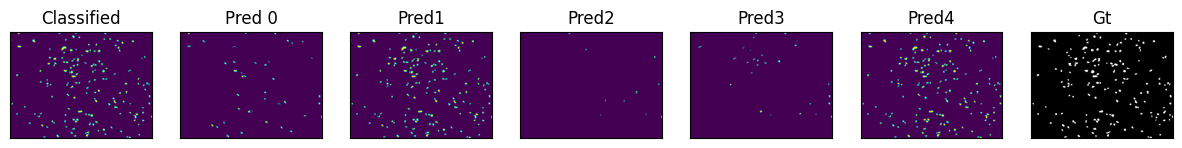

In [11]:
reconstructed_img_0 = get_reconstructed_image(label_img, all_predictions[0])
reconstructed_img_1 = get_reconstructed_image(label_img, all_predictions[1])
reconstructed_img_2 = get_reconstructed_image(label_img, all_predictions[2])
reconstructed_img_3 = get_reconstructed_image(label_img, all_predictions[3])
reconstructed_img_4 = get_reconstructed_image(label_img, all_predictions[4])
visualize(
    classified = get_reconstructed_image(label_img, filtered_ids),
    pred_0 = reconstructed_img_0,
    pred1 = reconstructed_img_1,
    pred2 = reconstructed_img_2,
    pred3 = reconstructed_img_3,
    pred4 = reconstructed_img_4,
    gt = gt
) 

In [12]:
len(all_predictions[0]),len(all_predictions[1]), len(all_predictions[2]), len(all_predictions[3]), len(all_predictions[4])

(51, 213, 14, 34, 213)